In [16]:
import numpy as np
import control
from control.matlab import *
import matplotlib.pyplot as plt

In [17]:
num = [1]
den = [1, 3, 2]
G = tf(num,den)

In [18]:
ts = 1e-2
T = 5
t = np.arange(0, T, ts)
u = np.random.normal(0, 1000, t.shape)

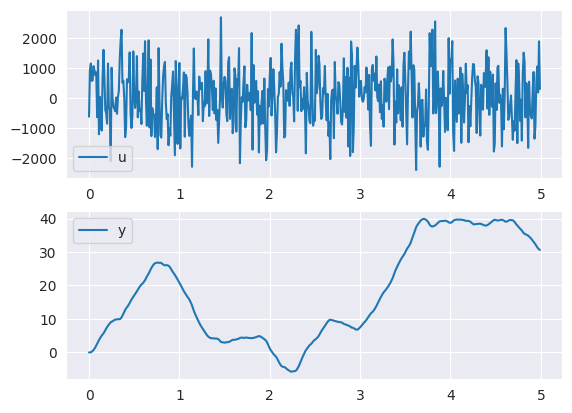

In [19]:
y, t, _ = lsim(G, u, t)
plt.subplot(211)
plt.plot(t, u, label="u")
plt.legend()
plt.subplot(212)
plt.plot(t, y, label="y")
plt.legend()

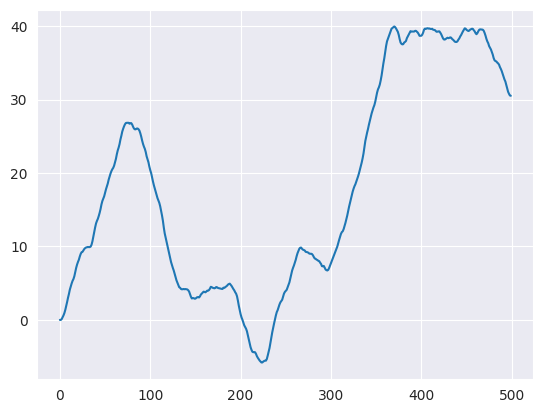

In [20]:
# reference
Ts = 1e-2
t_CL = np.arange(0, 5, Ts)
s = tf('s')
tau = 0.05  # s
M = 1 / (1 + (tau / (2 * np.pi)) * s)
M = M * (1 + 1e-2 * (tau / (2 * np.pi)) * s)  # add a high freq zero for inversion
# get virtual error
r = lsim(M ** (-1), y, t_CL)[0]
plt.plot(r)